In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as plt
import cv2
from matplotlib import image
import os
import numpy as np
from scipy import ndimage
from scipy.ndimage import morphology
import mach_functions


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def runFiltering(yamlFile):
    """
    Read in the parameters in the yamlFile and run the hierarchical filtering 
    """
    # load in parmeters
    Params = mach_functions.load_yaml(yamlFile)
    Filters = mach_functions.readInfilters(Params)
    Images = mach_functions.readInImages(Params)

    detectedCells = dict()
    if Params['PenaltyFilterOption'] == 1:
        print ("using the 'rodp' as penalty filter for rod cell detection")
        penaltyFilter = Filters['PenaltyFilters']['rodp']
        rodSNR = Params['rodSNR'][0]
    else:
        print ("using the 'rrodp' as penalty filter for rod cell detection")
        penaltyFilter = Filters['PenaltyFilters']['rrodp']
        rodSNR = Params['rodSNR'][1]
    
    # detect rod and remove the cells in the test image
    print ("Detecting the rod cells ---")
    detectedCells['rod'],crPlanes = mach_functions.giveRod(Images['grayImage'],Filters['NormalFilters']['rod'],penaltyFilter,\
                                                    snrthres=rodSNR,fragRodRefine=True,\
                                                        somaFilter=Filters['NormalFilters']['amoe'],
                                                        somathres=0.33,areaRefine=True,
                                                        )
    newtestImage = mach_functions.removeDetectedCells(Images['grayImage'],detectedCells['rod'],bgmthres=0.4)

    # detect ram and hyp
    print ("Detecting the ram/hyp cells ---")
    detectedCells['ram'], detectedCells['hyp'] = mach_functions.giveRamHyp(newtestImage,\
                                                 Filters['PartialFilters']['ramp'],\
                                                 Filters['PartialFilters']['hypp'],\
                                                 Params['rampThres'],\
                                                 Params['hyppThres'] )

    newtestImage = mach_functions.removeDetectedCells(newtestImage,detectedCells['ram'],bgmthres=0.4)
    newtestImage = mach_functions.removeDetectedCells(newtestImage,detectedCells['hyp'],bgmthres=0.4)

    # detect amoe and dys
    print ("Detecting the amoe/dys cells ---")
    detectedCells['amoe'],detectedCells['dys'] = mach_functions.giveAmoeDys(newtestImage,\
                                                                Filters['NormalFilters']['amoe'],\
                                                                Params['amoeThres'],\
                                                                Params['areaThres'])
    
    machresults = mach_functions.machPerformance(detectedCells,Images)

    return machresults


In [3]:
results = runFiltering("./Params.yaml")


using the 'rodp' as penalty filter for rod cell detection
Detecting the rod cells ---
Detecting the ram/hyp cells ---
Detecting the amoe/dys cells ---


get the performace score defined as $f = \sum W_{TP,i} (1-TP_i) + W_{FP,i}FP_i$ and save the TP/FP into a figure

rod
ram
hyp
amoe
dys


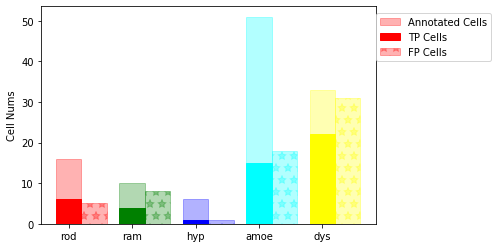

In [4]:
results.resetTPFPWeights()
results.calculateTPFP()
PFscore = results.calculatePFscore()
results.plotTPFPfigure("TPFP.png")

In [6]:
imgResult = results.giveImgResutls()

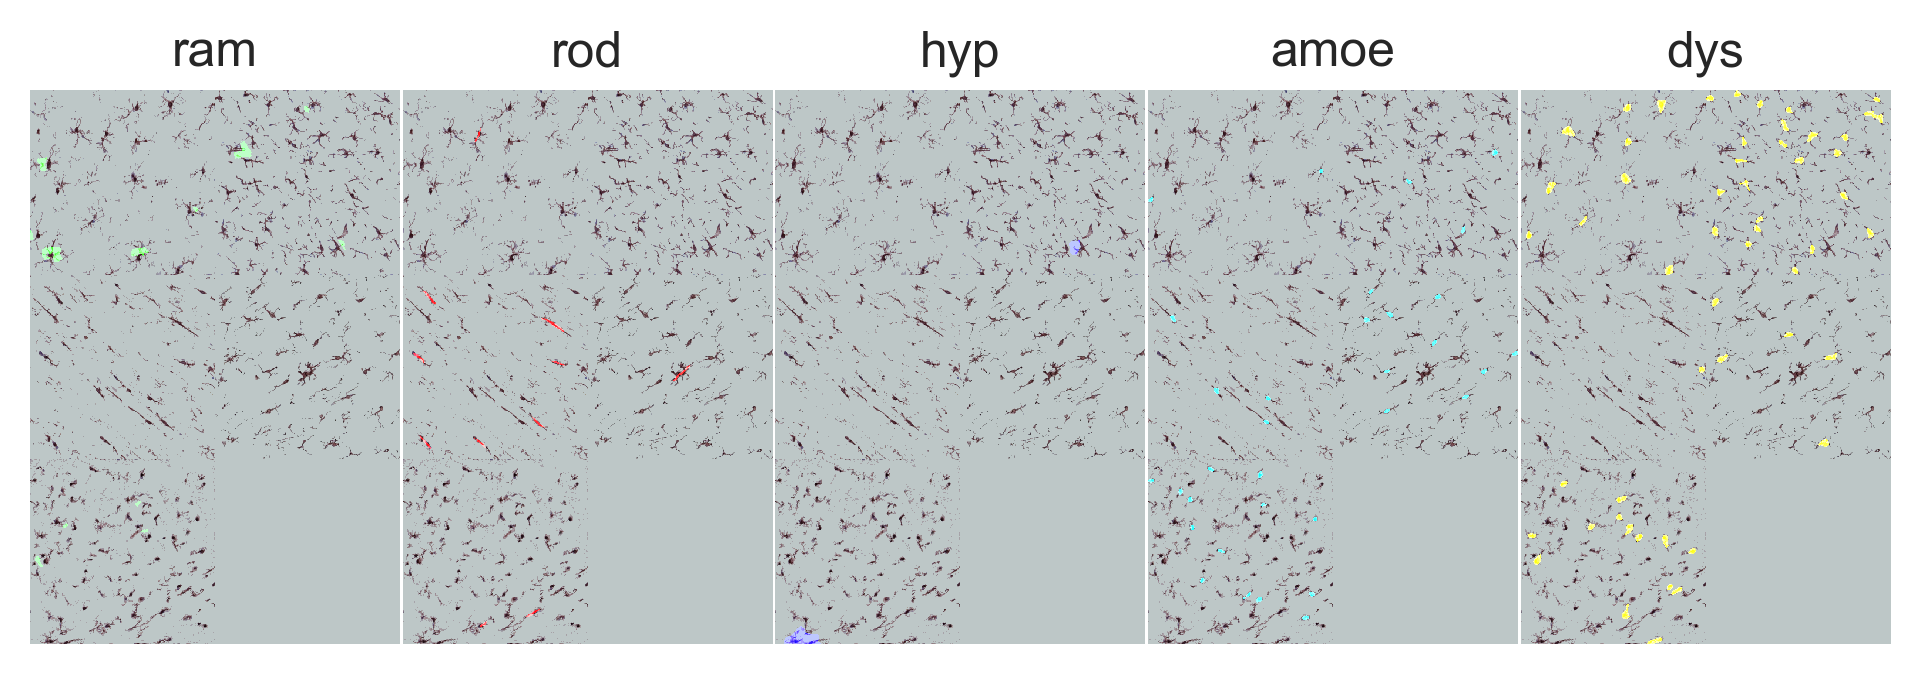

In [10]:
cases = ['ram','rod','hyp','amoe','dys']
plt.style.use('seaborn')
plt.figure(dpi=300)
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(imgResult[cases[i]])
    plt.xticks([])
    plt.yticks([])
    plt.title(cases[i])
plt.subplots_adjust(wspace=0.01)

In [11]:
print (PFscore)

5.669050802139038
